# Homework 1

### Due Date: Thursday, September 13, 2018

### Eugene agreed that I get an extension until next Thursday for my prolonged issues with SUMO. Please do not deduct late points.

### Getting Started

If you haven't installed Flow onto your computer at this point, it's highly recommended that you go to https://berkeleyflow.readthedocs.io/en/latest/flow_setup.html and follow the instructions to do so.
A few key points:
- This course is done in Python 3 and code in Python 2 will not be supported. Please upgrade if you haven't.
- It is highly recommended that you perform the installation in a virtual environment such an Anaconda.

# Question 1: Markov Decision Processes

Markov decision problems (MDPs) are an important prelude to all reinforcement learning applications, as they define the task space of the application in question. These MDPs consist of a tuple ($\mathcal{S}$, $\mathcal{A}$, $\mathcal{P}$, $r$), where:

- $\mathcal{S} \in \mathbb{R}^n$ is an $n$ dimensional state space
- $\mathcal{A} \in \mathbb{R}^m$ is an $m$ dimensional action space
- $\mathcal{P} : \mathcal{S} \times \mathcal{A} \times \mathcal{S} \to \mathbb{R}_+$ is a transition probability function
- $r : \mathcal{S} \to \mathbb{R}$ is a reward function

Note that MDPs are often characterized with other properties as well (e.g. a time horizon $T$), but for this problem we will consider the above representation.

### a. Fully autonomous intersections

Consider the fully autonomous intersection problem in the figure below, where vehicles are attempting to cross an intersection from either sides. In this problem, all vehicles in the network are fully autonomous and are equipped with sensors that can provide an arbitrary amount of state information. The objective is to develop a control strategy whereby all vehicles may pass the intersection as quickly as possible without colliding into one another.

<img src="img/two_way_intersection.png" width="400">

Given the above description, design an MDP that can be used to represent the above system.

- $\mathcal{S} \in ${survival: if the car is ok or busted, position: a vehicle is either a front car (about to enter the intersection) or a following car, pass: if it passes the intersection, $a_l$: acceleration of the vehicle in front of it, $v_i$: speed of the front vehicle on each direction, $d_i$: disntance of the front vehicle of each direction from the center of the intersection}. Also, based on those motion parameters the system shall be able to determine the front vehicle from which direction will first reach the intersection under the current state. We denote this as "first arrival".
- $\mathcal{A} \in$ {accelerate, decelerate} 
- $\mathcal{P} = 1$ for any combination of $\{s'|s,a\}$. P is always 1 because we are in full control of the vehicles and there should be no surprises (given no system failure).
- $r :$ r(busted, any) = 0. r(ok, following car, N/A, N/A): 3, r(ok, front car, pass, first arrival) = 5. r(ok, front car, not pass, first arrival) = 2, r(ok, front car, pass, not first arrival) = 2. r(ok, front car, not pass, not first arrival) = 5.

### b. "Markov" decision process?

Is the MDP you designed in section a) truly Markovian? Why or why not?

- Yes. Assuming no mechanical failure, we have full control over the state transitions (vehicle motions), and all concerned states are completely observable.

### c. Mixed autonomy intersections

Let as now consider an modification to the problem presented in section a) where only a subset of the vehicles are autonomous, while the rest are driven by humans and do not communicate with the autonomous vehicles. How does the inclusion of human vehicles affect the MDP presented in section a)? Is this problem Markovian? If not, what can be changed to make it Markovian?

- This problem is no longer Markovian because transition probabilities are no longer deterministic. We have no control over human drivers, and we can't necessarily observe all of their "states". I guess we cannot not make it Markovian unless we install controllers in those human drivers' brains...

# Question 2: Simulating and Stabilizing Traffic in a Ring Road

In this problem, we will consider the problem of stabilizing traffic in a straight highway while using a ring road network as a surrogate. The formation of traffic instabilities (often referred to as traffic congestion, stop-and-go traffic, traffic waves, etc.) in ring roads is a widely studied problem, as it is analytically tractable and has been empirically shown to generate similar instabilities in field studies (see [this video](https://www.youtube.com/watch?v=7wm-pZp_mi0)) as those witnessed in real network settings such as highways (see [this video](https://www.youtube.com/watch?v=6ZC9h8jgSj4)). A thorough explanation of these instabilities is left until later in the course; instead here we are interested in reproducing them in simulation and we will build a few controllers to try to counteract these instabilities.

We will simulate the performance of vehicles in a ring road using the microscopic traffic simulator SUMO. In order to setup a ring road network in SUMO and study the performance of different car-following models and controllers, we will use the computational framework Flow.

### a. Modeling microscopic car-following dynamics

We begin by implementing a car-following model that can recreate the types of traffic instabilities experienced in reality. Several car-following models exist to realistically depict the longitudinal (acceleration) behavior of vehicles in a network. One such model is the Intelligent Driver Model (IDM), in which the acceleration $a_{IDM}$ of a vehicle is defined as:

\begin{equation}
a_{IDM}(v, v_l, h) = a \bigg[ 1 - \bigg( \frac{v}{v_0} \bigg) ^\delta - \bigg( \frac{s^* (v, v_l)}{h} \bigg)^2 \bigg]
\end{equation}

where $v$ the vehicle's speed, $h$ is its bumper-to-bumper headway, $v_l$ is the speed of the vehicle ahead of it, and $s^*$ is the desired headway of the vehicle, denoted by:

\begin{equation}
s^*(v, v_l)  = s_0 + \max \bigg( 0, v T + \frac{v (v - v_l)}{2 \sqrt{ab}}  \bigg)
\end{equation}

where $s_0$, $v_0$, $T$, $\delta$, $a$, $b$ are given parameters that may be calibrated to model highway traffic.

Using the *BaseController* class in Flow, design a controller that can recreate the behavior of this model in simulation. You can create this controller class by filling in the below script. Use the following values for each of the model parameters:

- $s_0$: 2 m
- $v_0$: 30 m/s
- $T$: 1 s
- $\delta$: 4
- $a$: 1 m/s$^2$
- $b$: 1.5 m/s$^2$

For more information of designing controllers in Flow, we recommend you review this [tutorial](https://github.com/berkeleyflow/flow/blob/master/tutorials/tutorial07_controllers.ipynb). **Note**: You are allowed to import any module you find valuable.

In [14]:
import numpy as np
from flow.controllers import BaseController


class IDM(BaseController):

    def get_accel(self, env):
        # bumper-to-bumper headway
        h = env.vehicles.get_headway(self.veh_id)

        # speed of the current vehicle
        v = env.vehicles.get_speed(self.veh_id)

        # speed of the lead vehicle
        v_l = env.vehicles.get_speed(env.vehicles.get_leader(self.veh_id))

        ######################################
        ###### your implementation here ######
        s0 = 2
        v0 = 20
        T = 1
        δ = 4
        a = 1
        b = 1.4
        
        s_star = s0 + max(0, v*T+ v*(v-v_l)/(2*(a*b)**0.5))
        
        acceleration = a* (1 - (v/v0)**δ - (s_star/h)**2)
        ######################################
        ######################################

        # return the acceleration of the current vehicle
        return acceleration

### b. Preparing the simulation

Next, we will run the simulation in SUMO using the *SumoExperiment* class in Flow. This class allows us to specify the type of scenario we would like to simulate as well as the longitudinal and lateral dynamics of vehicles in the simulation. Referring to the [tutorial in Flow on simulating traffic](https://github.com/berkeleyflow/flow/blob/master/tutorials/tutorial01_sumo.ipynb), fill in the below parameters in order to produce an experiment with a single lane ring road network of length 260 m with a total of 22 vehicles following the IDM model from part a), where the vehicles are initially perturbed from equal spacing by an additive random normal term with standard deviation 1.0 m.

In [22]:
# some objects we will use to define the parameters of the simulation
from flow.core.params import EnvParams, SumoParams, NetParams, InitialConfig
from flow.core.vehicles import Vehicles
from flow.controllers.routing_controllers import ContinuousRouter

# these are the scenario and generator classes for the ring road (they do not need to be modified)
from flow.scenarios.loop.loop_scenario import LoopScenario
from flow.scenarios.loop.gen import CircleGenerator

# this is the environment we will be using during the simulation (it does not need to be modified)
from flow.envs.test import TestEnv

# the EnvParams object is left empty for the above environment (this does not need to be modified)
env_params = EnvParams()

######################################################
############ modify everything below here ############
######################################################

# add 22 vehicles with the "IDM" acceleration controller from section a)
vehicles = Vehicles()
vehicles.add("IDM",
             acceleration_controller=(IDM, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=22)  ### modify this function call ###

# modify the NetParams object to support a ring road of length 230 m
params = dict({'length': 230, 'speed_limit': 30, 'resolution': 40, 'lanes': 1})
net_params = NetParams(additional_params=params)  ### modify this class instantiation ###

# start all vehicles with perturbation standard deviation of 1.0 m
initial_config = InitialConfig(spacing="uniform", perturbation=1)  ### modify this class instantiation ###

# run the simulation with a simulation step of 0.1s and activate the GUI for visualization purposes
sumo_params = SumoParams(sim_step=0.1, sumo_binary="sumo-gui")  ### modify this class instantiation ###

Once the above parameters are ready, we can start the simulation using the code snippet below to see how well the network performs when the vehicles are initially perturbed. If your model and network are designed correctly, then after some time the vehicles should begin bunching together and accelerating quickly when they are at the front of the backwards propagating queue. This is known as a "stop-and-go wave".

In [23]:
from flow.core.experiment import SumoExperiment

scenario = LoopScenario(name="ring_road",
                        generator_class=CircleGenerator,
                        vehicles=vehicles,
                        net_params=net_params,
                        initial_config=initial_config)

env = TestEnv(env_params, sumo_params, scenario)

exp = SumoExperiment(env, scenario)
info_dict = exp.run(1, 3000)

print("------------------")
print("Average speed in final time step: {} m/s".format(info_dict["velocities"][0][-1]))

Round 0, return: 0
Average, std return: 0.0, 0.0
Average, std speed: 3.4150902104475462, 0.0
------------------
Average speed in final time step: 3.452124143342093 m/s


Fill in the variable **v_perturbed** below to get the the average speed of all vehicles in the network at the end of the simulation when the vehicles are perturbed. Then, rerun the above simulation when the initial perturbation is set to 0.0 m, and fill in **v_nonperturbed** with this value.

In [24]:
# average speed of all vehicles in the network at the end of the simulation when the vehicles are perturbed
v_perturbed = 2.397037326072389

# average speed of all vehicles in the network at the end of the simulation when the vehicles are not perturbed
v_nonperturbed = 3.452124143342093

### c. Designing a stabilizing controller

The perturbed a non-perturbed average speeds above given us a sense of how well the scenario can perform in the presence and absence of disturbances, respectively. Autonomous vehicles present a means of potentially alleviating the negative effects of the initial perturbation. Several approaches have been recommended to do so, some of which can roughly be reduced to:

- Drive at a speed close to but below the optimal speed (v_nonperturbed).
- Try to drive halfway between vehicle in front and behind.
- Accelerate and decelerate slowly so as not to return to the location of the wave before it has partially been attenuated.

Taking inspiration from these recommendations, or from your own understanding of the problem, design a controller in the code snippet below that can improve the performance of the network in terms of the final attained average velocity using only the speed of the ego vehicle and the speeds and bumper-to-bumper gaps with the lead and lag vehicles.

In [54]:
from flow.controllers import BaseController


class StabilizingController(BaseController):

    def get_accel(self, env):
        # speed of the current vehicle
        v = env.vehicles.get_speed(self.veh_id)

        # bumper-to-bumper headway with the lead vehicle
        h = env.vehicles.get_headway(self.veh_id)

        # speed of the lead vehicle
        v_l = env.vehicles.get_speed(env.vehicles.get_leader(self.veh_id))

        # bumper-to-bumper headway with the lag vehicle
        h_lag = env.vehicles.get_headway(env.vehicles.get_follower(self.veh_id))

        # speed of the lag vehicle
        v_lag = env.vehicles.get_speed(env.vehicles.get_follower(self.veh_id))

        ######################################
        ###### your implementation here ######
        s0 = 2
        v0 = v_nonperturbed
        T = 1
        δ = 4
        a = 1
        b = 1.4
        
        s_star = (h+h_lag)/2
        
        if v < v_nonperturbed:
            acceleration = a* (1 - (v/v0)**δ - (s_star/h)**2)
        else:
            acceleration = 0
        
        ######################################
        ######################################

        # return the acceleration of the current vehicle
        return acceleration

Finally, run the below script to see how well your controller performs. You may use this simulation and the resulting plot to adjust the parameters of your hand-designed controller.

Round 0, return: 0
Average, std return: 0.0, 0.0
Average, std speed: 2.953139356483123, 0.0


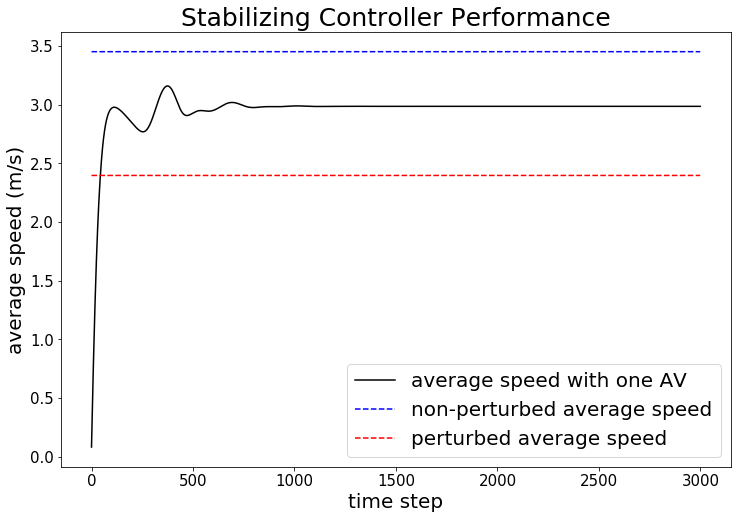

In [55]:
##########################################
######## Simulating AV controller ########
##########################################

# length of one simulation, in time steps
NUM_STEPS = 3000

# we now have 21 vehicles using the IDM model and one using the above AV controller
vehicles = Vehicles()
vehicles.add(veh_id="human", 
             acceleration_controller=(IDM, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=21)
vehicles.add(veh_id="AV", 
             acceleration_controller=(StabilizingController, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

# the scenario and environment remain the same
scenario = LoopScenario(name="ring_road",
                        generator_class=CircleGenerator,
                        vehicles=vehicles,
                        net_params=net_params,
                        initial_config=initial_config)

env = TestEnv(env_params, sumo_params, scenario)

exp = SumoExperiment(env, scenario)
info_dict = exp.run(1, NUM_STEPS)


##########################################
############ Plotting results ############
##########################################

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(info_dict["velocities"][0], c='k', label="average speed with one AV")
plt.plot([v_nonperturbed] * NUM_STEPS, '--', c='b', label="non-perturbed average speed")
plt.plot([v_perturbed] * NUM_STEPS, '--', c='r', label="perturbed average speed")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### d. Checking the generalizability of the controller

Now that we have designed a control strategy that can at least somewhat dissipate the formation of waves in a 260 m ring road with 22 vehicles following a deterministic car-following model, let us consider a more difficult representation of the problem. In the below cell, we place the above controller on a denser 230 m ring road where the accelerations dictated to the individual vehicles by the Intelligent Driver Model are augmented by an additional exongenuous gaussian term $\mathcal{N} \sim (0, 0.2)$ to model the stochasticity of human driver behavior.

Run the below cell (**note**: you do not have to modify your controller for this problem). Then, list 1-2 potential deficiencies of your controller. Some questions you may want to ask yourself include:
- Is your controller generalizable enough to handle this new setting? 
- Is it transferable, for instance, to straight highways, and networks with multiple lanes were vehicles can move laterally as well?

Round 0, return: 0
Average, std return: 0.0, 0.0
Average, std speed: 2.9495018683201577, 0.0


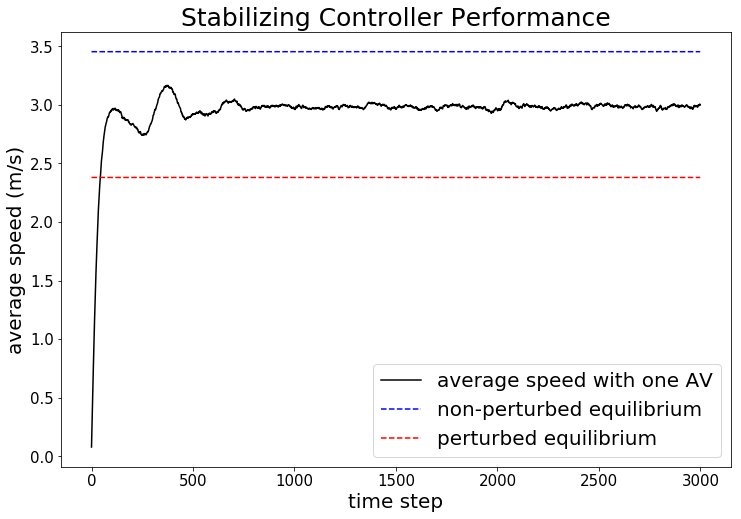

In [56]:
#########################################################
######## Simulating AV controller in new setting ########
#########################################################

# length of one simulation, in time steps
NUM_STEPS = 3000

# we now have 21 vehicles using the IDM model and one using the above AV controller
vehicles = Vehicles()
vehicles.add(veh_id="human", 
             acceleration_controller=(IDM, {"noise": 0.2}),  # the "noise" term is used to add exogenous noise
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=21)
vehicles.add(veh_id="AV", 
             acceleration_controller=(StabilizingController, {}),
             routing_controller=(ContinuousRouter, {}),
             num_vehicles=1)

# we modify the length of the network from its net_params component
net_params.additional_params["length"] = 230

# all other components of the scenario and environment remain the same
new_scenario = LoopScenario(name="ring_road",
                            generator_class=CircleGenerator,
                            vehicles=vehicles,
                            net_params=net_params,
                            initial_config=initial_config)

env = TestEnv(env_params, sumo_params, new_scenario)

exp = SumoExperiment(env, new_scenario)
info_dict = exp.run(1, NUM_STEPS)


##########################################
############ Plotting results ############
##########################################

# v_perturbed and v_nonperturbed for this problem are different,
# however, they can be calculated in the same way
v_perturbed_new = 2.380637680521127
v_nonperturbed_new = 3.4540661790240335

import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title("Stabilizing Controller Performance", fontsize=25)
plt.xlabel("time step", fontsize=20)
plt.ylabel("average speed (m/s)", fontsize=20)
plt.plot(info_dict["velocities"][0], c='k', label="average speed with one AV")
plt.plot([v_nonperturbed_new] * NUM_STEPS, '--', c='b', label="non-perturbed equilibrium")
plt.plot([v_perturbed_new] * NUM_STEPS, '--', c='r', label="perturbed equilibrium")
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

It seems that my stabilizer is generalized enough for this problem's setting. However I'm not satisfied with its improvement of the average speed. The achieved average speed is only half way between the ideal and baseline situations, and we should do better. Straight highway should not an issue, since it is basically the same as a ring road. However, this controller may not be traferrable to a multi-lane highway. A multi-lane system will be more stochastic when vehicles are allowed to pass each other, and their behavior can no longer be modeled with the simple formulas used in this problem. In fact, this controller does not consider lane changing at all. 

# Question 3: Value/Bellman Iteration
Value iteration is a key idea that underlies a lot of reinforcement learning, in particular Q-Learning, which 20 years later is still an incredibly popular algorithm. To make sure that you have a good understanding of value iteration as a solution to the Bellman equation, this exercise takes you through three ways of solving the Bellman equations.

Let's take an over-simplified traffic light example. Imagine you have a two-way intersection with traffic travelling only North-South or East-West (similar to question 1). Because traffic can only flow in one direction at a time, whenever the light is green in one direction a queue will begin to form in the other. To keep the number of states small, let us characterize the queues that form as either High (corresponding to large number of vehicles) or Low (corresponding to very few vehicles in the queue). The state space of this problem is then:

\begin{equation}
\mathcal{S}: \{\text{Low-Low, Low-High, High-Low, High-High}\}
\end{equation}

where the first element is associated with the North-South queue and the second with the East-West queue. 

Treating the controllable agents in the problem as the traffic lights at the intersection, the actions are simply to switch the state of the traffic light to be green on either the North-South ($\updownarrow$) or East-West ($\leftrightarrow$) directions:

\begin{equation}
\mathcal{A}: \{ \updownarrow, \leftrightarrow \}
\end{equation}

In this situation, we want to minimize total queue formation; subsequently, we formulate our reward $R(s,a)$ as

$$
\begin{array}{|c|c|c|}
\hline 
 s                & a & R(s,a) \\
\hline
 \text{Low-Low}   & \updownarrow / \leftrightarrow & 3 \\ \hline
 \text{High-Low}  & \updownarrow / \leftrightarrow & 2 \\ \hline
 \text{Low-High}  & \updownarrow / \leftrightarrow & 2 \\ \hline
 \text{High-High} & \updownarrow / \leftrightarrow & 1 \\ \hline
\end{array}
$$

In order to model the dynamics of the intersection, we will use a simplistic stochastic transition function $P(s' | s, a)$. Note that the true transition function is probably a good deal more complicated.

$$
\begin{array}{|c|c|c|c|}
\hline
s' & s & a & P(s'|s,a)\\ \hline
\text{Low-High}  & \text{Low-Low}   & \updownarrow & 0.5  \\ \hline
\text{Low-Low}   & \text{Low-Low}   & \updownarrow & 0.5  \\ \hline
\text{High-Low}  & \text{Low-Low}   & \leftrightarrow & 1.0  \\ \hline
\text{High-High} & \text{High-Low}  & \updownarrow & 0.25 \\ \hline
\text{Low-High}  & \text{High-Low}  & \updownarrow & 0.25 \\ \hline
\text{Low-Low}   & \text{High-Low}  & \updownarrow & 0.5  \\ \hline
\text{High-Low}  & \text{High-Low}  & \leftrightarrow & 1.0 \\ \hline
\text{High-Low}  & \text{Low-High}  & \leftrightarrow & 1.0 \\ \hline
\text{Low-High}  & \text{Low-High}  & \updownarrow & 1.0 \\ \hline
\text{Low-High}  & \text{High-High} & \updownarrow & 1.0 \\ \hline
\text{High-Low}  & \text{High-High} & \leftrightarrow & 1.0 \\ \hline
\end{array}
$$

### a. Explicit solutions of the Bellman equations
The analytic form of the solution to the Bellman equations is:

$$V^*(s) = \underset{a}{\text{max}} \ \left[R(s,a) + \gamma \sum_{s'}P(s'|s,a)V^*(s')\right]$$

Because of the "max" argument on the outside, this problem is non-linear and very difficult to solve analytically. However, if instead we want to just solve for the value function with respect to a fixed policy, then the maximization term disappears and we can instead solve a linear set of equations.

Consider the following policy $\pi$:
$$
\begin{array}{|c|c|}
\hline 
 s & \pi(s) \\
\hline
 \text{Low-Low} & \updownarrow \\ \hline
 \text{High-Low} & \updownarrow \\ \hline
 \text{Low-High} & \leftrightarrow \\ \hline
 \text{High-High} & \updownarrow \\ \hline
\end{array}
$$

Set up a set of linear equations that can be used to solve for the value function $V^\pi$ for each of the four states.

### b. Value iteration
Now, suppose we want to solve for the value function for the optimal policy. Denoting the initial value function as $V^0(s)$, initialize the value function as $V^0(s) = R(s)$, and perform one round of policy iteration to compute $V^1(s)$. Assume a discount value $\gamma = 0.5$.

R(L-L) = 3, R(H-L) = 2, R(L-H) = 2, R(H-H) = 1

For one iteration,

$V(L-L) = 3 + 0.5[(0.5 \times 2 + 0.5 \times 3)] = 4.25$

$V(H-L) = 2 + 0.5[(0.25 \times 1 + 0.25 \times 2 + 0.5 \times 3)] = 3.125$

$V(L-H) = 2 + 0.5[(1 \times 2)] = 3$

$V(H-H) = 1 + 0.5[(1 \times 2)] = 2$

### c. Computational solution
Computing one round of policy iteration takes quite a while by hand. So now that you've built up some intuition for it, set up some code to perform further value of iterations. Run the code until one of these two conditions are reached:

1. 150 sets of value iteration have occured.
2. The smallest change in the value function of any state is less than .01. In more mathematical terms, the termination condition is: $ \text{min }|V^t(s) - V^{t+1}(s)|<.01 \ \ \  \forall s\in \mathcal{S} $

Note that the second condition should be reached well before the first. If you're hitting the first, there's probably something wrong with your code.

In [241]:
#############################################
####### add value iteration code here #######
#############################################
rewards = dict()
rewards['L-L'] = 3
rewards['H-L'] = 2
rewards['L-H'] = 2
rewards['H-H'] = 1
policy_prob = dict()
# probability, s'
policy_prob['L-L'] = [(0.5, 'L-L'), (0.5, 'L-H')]
policy_prob['H-L'] = [(0.25, 'H-H'), (0.25, 'L-H'), (0.5, 'L-L')]
policy_prob['L-H'] = [(1, 'H-L')]
policy_prob['H-H'] = [(1, 'L-H')]
γ = 0.5
maxiter = 150

               #coefficient = prob*γ, reward value, next stage
this_stage = [[(1, 3, 'L-L')], [(1, 2, 'H-L')], [(1, 2, 'L-H')], [(1, 1, 'H-H')]]
diff = 100
count = 0
this_value = [3, 2, 2, 1]

def iteration(value, stage):
    next_stage = []
    new_value = value
    for s in stage:
        policy_s = policy_prob[s[2]]
        for c in policy_s:
            c_coeff = s[0]*c[0]*γ
            c_stage = c[1]
            #print(c)
            c_value = c_coeff*rewards[c_stage]
            next_stage.append((c_coeff, c_value, c_stage))
            new_value += c_value
    return new_value, next_stage

four_diff = [0, 0, 0, 0]
while diff >= 0.01 and count <= maxiter:
    old_stage = this_stage
    old_value = this_value.copy()
    for i in range(0,4):
        this_value[i], this_stage[i] = iteration(old_value[i], old_stage[i])
        four_diff[i] = abs(this_value[i] - old_value[i])
    diff = max(four_diff)
    count += 1

In [243]:
print("V(L-L), V(H-L), V(L-H, V(H-H) = ", this_value)

V(L-L), V(H-L), V(L-H, V(H-H) =  [5.364776611328125, 4.2322540283203125, 4.1117706298828125, 3.051513671875]


### d. Conceptual check

Pretend for a second that the value functions you've computed above are the optimal value functions (which they would be if you ran them long enough to make the error essentially zero). Given the optimal value functions and the transition functions, how would you find the optimal policy for any given state?

$V^\pi(s) = \sum_a{\pi(a|s)r(s,a)} + \gamma\sum_a{\pi(a|s)\sum_{s'}p(s'|s,a)V^\pi(s')}$. So I will calculate the  the respective possibility times the reward of each state that can result from an action, and do this for every possible action for the current state, and find the action that results in the highest reward. This will be the optimal policy for the current state.

# Question 4: Why Stochastic Gradient Descent?

In this problem we're going to explore the value of stochastic gradient descent and answer the following question: If you know the true gradient, what's the point of using stochastic gradient descent?

Before we move on to trying out gradient descent and its variants to an interesting transportation problem, let's try a few examples to illustrate the power of gradient descent and the speed-boost we can pick up from stochastic gradient descent. 

We are trying to find a linear function that can be used to identify when a point is in one of two classes. The goal here is to find a weight vector $\vec{w} \in \mathbb{R}^n$ that we can use to classify a sample $x_i$ as label -1 if $\vec{w} \cdot \vec{x_i} > 0$ and label 1 if $\vec{w} \cdot \vec{x_i} < 0$. Geometrically, a sample is in class 1 if it is on the same side of the hyper-plane as the weight vector. 

Let's start with a low-dimensional linear-classification example. First, let's generate some data. Because of the way we generate this data, we can guarantee that it can be separated by a hyper-plane. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(dim, batch_size=5000, visualize=False):
    """
    Returns batch_size of vectors of length-dim, their associated labels, and the hyperplane used to generate them. 
    Labels are sampled from a random hyper-plane
    """
    weights = np.random.rand(dim)
    data = np.random.rand(batch_size, dim) - 0.5
    labels = np.zeros(batch_size)
    labels[np.dot(data, weights) > 0] = -1
    labels[np.dot(data, weights) < 0] = 1
    if visualize:
        fig = plt.scatter(data[:,0], data[:,1], c=labels, cmap='bwr')
        plt.show()
    return data, labels, weights

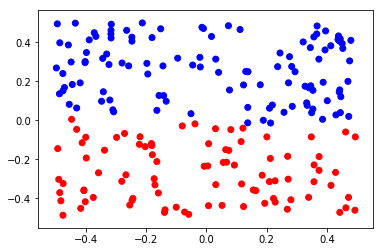

The weights of the hyper-plane are: [ 0.01753255  0.1627844 ]


In [29]:
data, labels, true_weight = generate_data(dim=2, batch_size=200, visualize=True)
print("The weights of the hyper-plane are:", true_weight)

Now, for the purposes of illustration, we've actually returned the true weight vector but in general you might get data sampled from some random distribution and want to classify it. So, let's pretend we don't know the weight vector and attempt to recover it via gradient descent. To do so, we need a metric that tells you whether the weight vector is classifying things correctly. 
There are a lot of popular choices for loss functions, but for the purpose of simplicity let's use the following classification scheme.

Notice from the sample implementation that if a data-point $x_i$ has $\vec{w}\cdot x_i > 0$ then its label $l_i$ is -1 so define:

$$z_i = \vec{w}\cdot x_i$$

We have that $l_i z_i < 0$ for everything with label -1. The same is true for all the points with label 1! So, if we compute $z_i$ for a given point with our test weight vector and it's positive, then we've got a misclassified sample! Motivated by this, let's define the loss as 

\begin{equation}
L = \frac{1}{N} \sum_{i=0}^N L(z_i, l_i)
\end{equation}

where:

\begin{equation}
L(z_i, l_i) =
\begin{cases}
0 & l_i z_i < 0 \\
l_i z_i & l_i z_i > 0 \\
\end{cases}
\end{equation}

Now if we sum up over these, if the sum isn't zero, there's still a mis-classified point.

In [30]:
# an initial weight
w0 = np.random.rand(2)

def loss(weight, data, labels):
    errors =  labels * np.dot(data, weight)
    errors = errors[errors > 0]
    return 1/data.shape[0] * np.sum(errors)

# evaluate the loss to start
loss(w0, data, labels)

0.042174591820168812

Now that we've shown how to set up a classification loss and generate the data, please solve the following problems:

1. Generate a batch of 100000 data points of dimension two. For this data, compute the time to reduce the loss below .001 for batch sizes from 100 to a full batch in 10x increments. The full batch corresponds to normal gradient descent. Plot the batch-size vs. the time taken to convergence. Finally, in order to validate that your SGD operation is in fact converging to the right solution, print the normalized set of true hyper-plane parameters and the parameters you received in the 100 batch size case. **Warning**: do not recreate the data for each batch-size test as this can corrupt your results.
2. Repeat the above problem but make the dimension of the data 50. 

**Hints**: 
- You can play around with the step-size, but a good starting point is often .01
- Make sure to keep the step-size the same across batches, otherwise your comparison is invalid.

Hopefully after this you can see why stochastic gradient descent is such a beloved technique, at least from the perspective of sample efficiency.

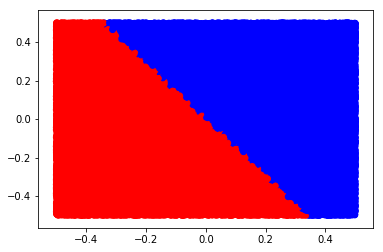

The weights of the hyper-plane are: [ 0.48343049  0.32868223]


In [237]:
#################################
####### add SGD code here #######
#################################
data, labels, true_weight = generate_data(dim=2, batch_size=100000, visualize=True)
print("The weights of the hyper-plane are:", true_weight)

Gradient dL/dw = label*x

In [238]:
w0 = np.random.rand(2)

In [239]:
import random as rand
import time

indices = list(range(100000))
step_size = 0.001
weights = []
times = []
for i in range(2,6):
    n = 10**i
    if i < 5:
        sample = rand.sample(indices, n)
        this_data = data[sample]
        this_labels = labels[sample]
    else:
        this_data = data
        this_labels = labels
    weight = w0
    start = time.time()    
    old = this_labels
    while loss(weight, this_data, this_labels) >= 0.001:
        errors =  this_labels * np.dot(this_data, weight)
        loss_grad = this_data * this_labels.reshape((n, 1))
        loss_grad = loss_grad[(errors > 0).reshape(n,)]
        grad = sum(loss_grad)
        weight = weight - 2/n*step_size*grad
    end = time.time()
    weights.append(weight)
    print(end-start)

0.058789968490600586
0.06348419189453125
0.6642348766326904
5.970131874084473


In [244]:
weights

[array([ 0.51108772,  0.41652233]),
 array([ 0.48719302,  0.45087337]),
 array([ 0.49274289,  0.44301176]),
 array([ 0.49271688,  0.44326319])]

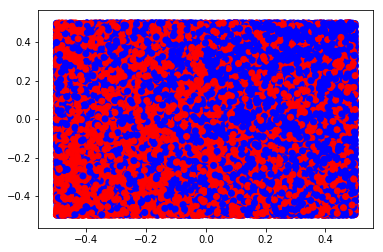

The weights of the hyper-plane are: [ 0.99322451  0.63487787  0.74445105  0.06256685  0.45652988  0.81790269
  0.9253827   0.30902506  0.04666183  0.7555176   0.0753452   0.76360539
  0.47804628  0.85329249  0.72889414  0.76446822  0.18627148  0.13118888
  0.06692     0.15489166  0.93689283  0.79579464  0.70372561  0.11736859
  0.89034577  0.46532617  0.11030304  0.75961842  0.48711734  0.06678468
  0.18916428  0.43825992  0.60271002  0.92100844  0.33397687  0.54816314
  0.95207146  0.53656779  0.03271412  0.34326749  0.86851859  0.62400904
  0.91924479  0.88818845  0.88686443  0.66931463  0.52926383  0.30848358
  0.44548246  0.34343678]


In [246]:
# dimension = 50
data, labels, true_weight = generate_data(dim=50, batch_size=100000, visualize=True)
print("The weights of the hyper-plane are:", true_weight)

In [247]:
indices = list(range(100000))
step_size = 0.01
w0 = np.random.rand(50)
weights = []
times = []
for i in range(2,6):
    n = 10**i
    if i < 5:
        sample = rand.sample(indices, n)
        this_data = data[sample]
        this_labels = labels[sample]
    else:
        this_data = data
        this_labels = labels
    weight = w0
    start = time.time()
    while loss(weight, this_data, this_labels) >= 0.001:
        errors =  this_labels * np.dot(this_data, weight)
        loss_grad = this_data * this_labels.reshape((n, 1))
        loss_grad = loss_grad[(errors > 0).reshape(n,)]
        grad = sum(loss_grad)
        weight = weight - 2/n*step_size*grad
    end = time.time()
    weights.append(weight)
    print(end-start)

0.0970313549041748
0.9984331130981445
13.386920928955078
135.30590891838074


In [248]:
weights

[array([ 0.6330673 ,  0.26303863,  0.8172699 ,  0.37641274,  0.56501513,
         0.86730271,  0.61008135,  0.51291261,  0.26925653,  0.29712863,
         0.50590939,  0.80580277,  0.5548948 ,  1.18826951,  0.67389582,
         0.70269109,  0.45464071,  0.30779717, -0.00818739,  0.34829054,
         0.51082411,  0.35563109,  0.48911979,  0.14651383,  0.71663585,
         0.58627313,  0.45346718,  0.41751301,  0.66079651,  0.5917783 ,
         0.51878575,  0.36911275,  0.42835676,  0.84205913,  0.35882611,
         0.17904732,  0.32009343,  0.53995402,  0.54034087,  0.58122922,
         0.39679243,  0.39891795,  0.87015138,  0.72502728,  0.41080304,
         0.63807459,  0.26172686,  0.55600274,  0.8798441 ,  0.76381783]),
 array([ 0.73656973,  0.47955893,  0.64203901,  0.17572549,  0.37443424,
         0.71077282,  0.82339393,  0.38340658, -0.00914376,  0.59964019,
         0.1289408 ,  0.70971942,  0.46030418,  0.77269401,  0.66271944,
         0.50274696,  0.06760991,  0.17354171,  0

We can observe that stochastic gradient descent does significantly reduce the run time. It can be observed that the complexity of gradient descent is O(log(n))? 